# Q1

In [1]:
import numpy as np

# 解析 TSP 文件
def parse_tsp(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        cities = []
        for line in lines:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
        return cities

# 计算两点间距离
def distance(city1, city2):
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

# 计算路径长度
def path_length(cities, tour):
    total_distance = 0
    for i in range(len(tour)):
        total_distance += distance(cities[tour[i-1]], cities[tour[i]])
    return total_distance

# 2-opt 算法
def two_opt_swap(tour, i, j):
    new_tour = list(tour[:i])
    new_tour.extend(reversed(tour[i:j + 1]))
    new_tour.extend(tour[j + 1:])
    return np.array(new_tour)


# 解析 .opt.tour 文件，以比较最优路径长度
def parse_opt_tour(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        opt_tour = []
        for line in lines:
            parts = line.split()
            if parts[0].isdigit():
                opt_tour.append(int(parts[0]) - 1)  # 减1是因为TSP文件通常从1开始编号，而Python列表从0开始
        return opt_tour

# 根据 .opt.tour 文件计算路径长度
def calculate_opt_length(cities, opt_tour):
    total_distance = 0
    for i in range(len(opt_tour)):
        total_distance += distance(cities[opt_tour[i - 1]], cities[opt_tour[i]])
    return total_distance

# 模拟退火算法
def simulated_annealing(cities, initial_temp, final_temp, alpha):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(cities))
    current_length = path_length(cities, current_tour)
    
    while current_temp > final_temp:
        i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
        new_tour = two_opt_swap(current_tour, i, j)
        new_length = path_length(cities, new_tour)
        
        if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
            current_tour = new_tour
            current_length = new_length
            
        current_temp *= alpha
    
    return current_tour, current_length

# 解析 eli51.tsp 和 eli51.opt.tour 文件
cities = parse_tsp('eil51.tsp.txt')
opt_tour = parse_opt_tour('eil51.opt.tour.txt')
opt_length = calculate_opt_length(cities, opt_tour)



多次运行后找到的最佳路径长度: 479.38553577777776
最优路径长度: 429.983311983384


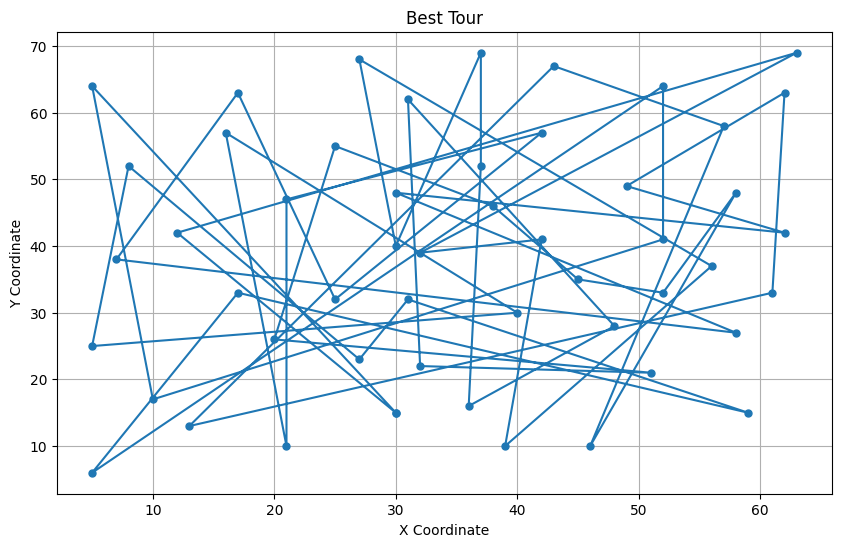

In [2]:

import matplotlib.pyplot as plt

def plot_tour(cities, tour):
    plt.figure(figsize=(10, 6))

    # Adjust for zero indexing if necessary
    adjusted_tour = [city_index - 1 for city_index in tour]

    x = [cities[i][0] for i in adjusted_tour]
    y = [cities[i][1] for i in adjusted_tour]

    # Close the tour by connecting the last city to the first
    x.append(x[0])
    y.append(y[0])

    plt.plot(x, y, 'o-', markersize=5)
    plt.title("Best Tour")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

def multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha):
    best_tour = None
    best_length = float('inf')
    
    for _ in range(runs):
        tour, length = simulated_annealing(cities, initial_temp, final_temp, alpha)
        if length < best_length:
            best_length = length
            best_tour = tour
    
    return best_tour, best_length


# 设置参数
runs = 1  # 运行次数
initial_temp = 15000  # 初始温度
final_temp = 0.001    # 最终温度
alpha = 0.999         # 冷却率

# 运行模拟退火算法多次
best_tour, best_length = multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha)

print("多次运行后找到的最佳路径长度:", best_length)
#print("模拟退火找到的路径长度:", length)
print("最优路径长度:", opt_length)

# Plotting the best tour found
plot_tour(cities, best_tour)

# Q2

Linear Cooling: 7885.4924803856275
Exponential Cooling: 2935.4660647623164
Logarithmic Cooling: 16462.8804015031


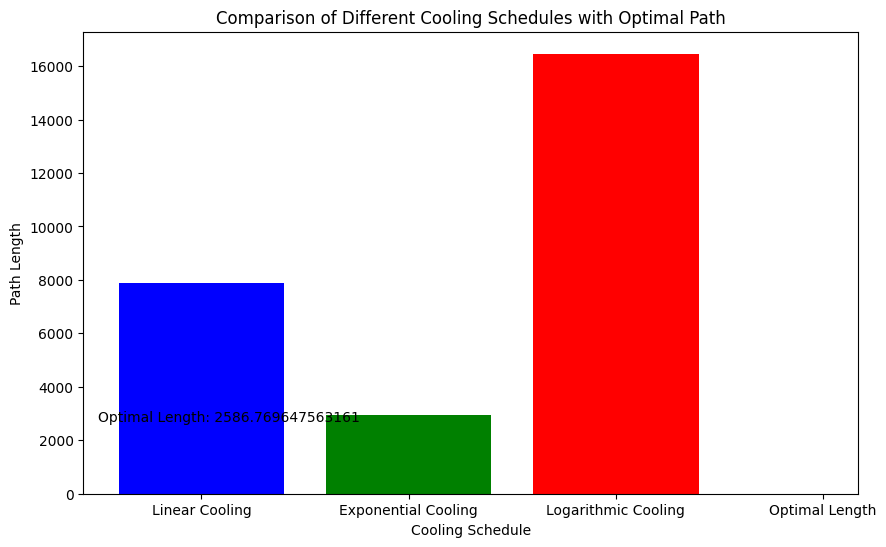

In [3]:
# 不同冷却策略
# 修改模拟退火算法以适应不同的冷却计划
def simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    best_tour = np.random.permutation(len(cities))
    best_length = path_length(cities, best_tour)
    iteration = 1

    while current_temp > final_temp:
        for _ in range(len(cities)):
            i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
            new_tour = two_opt_swap(best_tour, i, j)
            new_length = path_length(cities, new_tour)

            if new_length < best_length or np.random.rand() < np.exp((best_length - new_length) / current_temp):
                best_tour = new_tour
                best_length = new_length

        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1

    return best_length

# 不同的冷却计划
def linear_cooling(current_temp, alpha):
    return current_temp - alpha

def exponential_cooling(current_temp, alpha):
    return current_temp * alpha

def logarithmic_cooling(current_temp, alpha, iteration):
    return current_temp / (1 + alpha * np.log(1 + iteration))

# 多次运行模拟退火算法
def multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, cooling_schedule):
    best_length = float('inf')
    
    for _ in range(runs):
        length = simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule)
        if length < best_length:
            best_length = length
    
    return best_length

# 解析 TSP 和 OPT 文件
cities = parse_tsp('a280.tsp.txt')  # 替换为 a280.tsp 文件的实际路径
opt_tour = parse_opt_tour('a280.opt.tour.txt')  # 替换为 a280.opt.tour 文件的实际路径
opt_length = calculate_opt_length(cities, opt_tour)

# 设置参数并运行模拟退火算法多次
runs = 1  # 运行次数
initial_temp = 10000  # 初始温度
final_temp = 1        # 最终温度
alpha = 0.997         # 冷却率

# 运行模拟退火算法并比较不同冷却计划
cooling_strategies = {
    "Linear Cooling": lambda temp, alpha, _: linear_cooling(temp, alpha),
    "Exponential Cooling": lambda temp, alpha, _: exponential_cooling(temp, alpha),
    "Logarithmic Cooling": logarithmic_cooling
}

results = {}
for name, strategy in cooling_strategies.items():
    best_length = multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, strategy)
    results[name] = best_length
    print(f"{name}: {best_length}")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red'])
plt.plot(['Optimal Length'] * 2, [opt_length, opt_length], color='black', linestyle='--')
plt.text(-0.5, opt_length, f'Optimal Length: {opt_length}', verticalalignment='bottom')
plt.xlabel('Cooling Schedule')
plt.ylabel('Path Length')
plt.title('Comparison of Different Cooling Schedules with Optimal Path')
plt.show()

Linear Cooling: 7851.5609200333765
Exponential Cooling: 2927.0931932705716
Logarithmic Cooling: 17377.702782544704


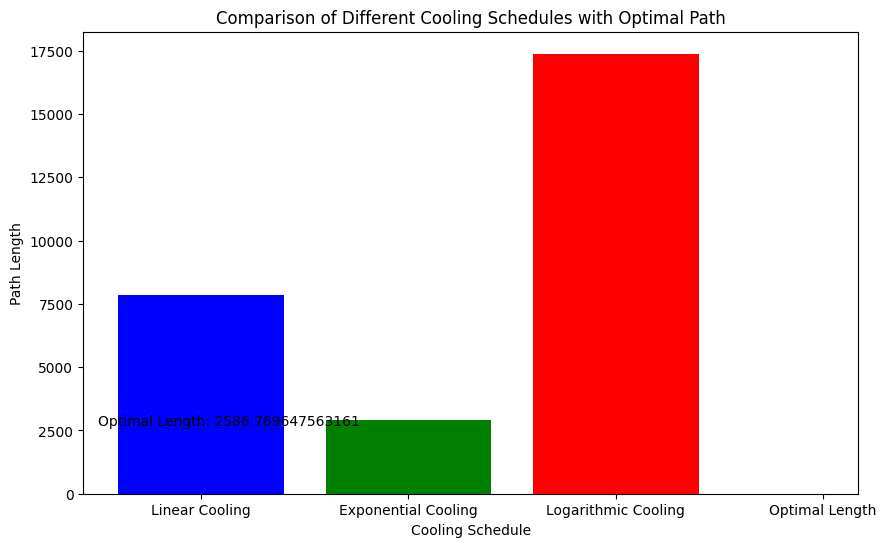

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 不同冷却策略
# 修改模拟退火算法以适应不同的冷却计划
def simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    best_tour = np.random.permutation(len(cities))
    best_length = path_length(cities, best_tour)
    iteration = 1

    while current_temp > final_temp:
        for _ in range(len(cities)):
            i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
            new_tour = two_opt_swap(best_tour, i, j)
            new_length = path_length(cities, new_tour)

            if new_length < best_length or np.random.rand() < np.exp((best_length - new_length) / current_temp):
                best_tour = new_tour
                best_length = new_length

        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1

    return best_length

# 不同的冷却计划
def linear_cooling(current_temp, alpha, iteration):
    return current_temp - alpha

def exponential_cooling(current_temp, alpha, iteration):
    return current_temp * alpha

def logarithmic_cooling(current_temp, alpha, iteration):
    return current_temp / (1 + alpha * np.log(1 + iteration))

# 多次运行模拟退火算法
def multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, cooling_schedule):
    best_length = float('inf')
    
    for _ in range(runs):
        length = simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule)
        if length < best_length:
            best_length = length
    
    return best_length

# 解析 TSP 和 OPT 文件
cities = parse_tsp('a280.tsp.txt')  # 替换为 a280.tsp 文件的实际路径
opt_tour = parse_opt_tour('a280.opt.tour.txt')  # 替换为 a280.opt.tour 文件的实际路径
opt_length = calculate_opt_length(cities, opt_tour)

# 设置参数并运行模拟退火算法多次
runs = 1  # 运行次数
initial_temp = 10000  # 初始温度
final_temp = 1        # 最终温度
alpha = 0.997         # 冷却率

# 运行模拟退火算法并比较不同冷却计划
cooling_strategies = {
    "Linear Cooling": lambda temp, alpha, _: linear_cooling(temp, alpha),
    "Exponential Cooling": lambda temp, alpha, _: exponential_cooling(temp, alpha),
    "Logarithmic Cooling": logarithmic_cooling
}

results = {}
for name, strategy in cooling_strategies.items():
    best_length = multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, strategy)
    results[name] = best_length
    print(f"{name}: {best_length}")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red'])
plt.plot(['Optimal Length'] * 2, [opt_length, opt_length], color='black', linestyle='--')
plt.text(-0.5, opt_length, f'Optimal Length: {opt_length}', verticalalignment='bottom')
plt.xlabel('Cooling Schedule')
plt.ylabel('Path Length')
plt.title('Comparison of Different Cooling Schedules with Optimal Path')
plt.show()

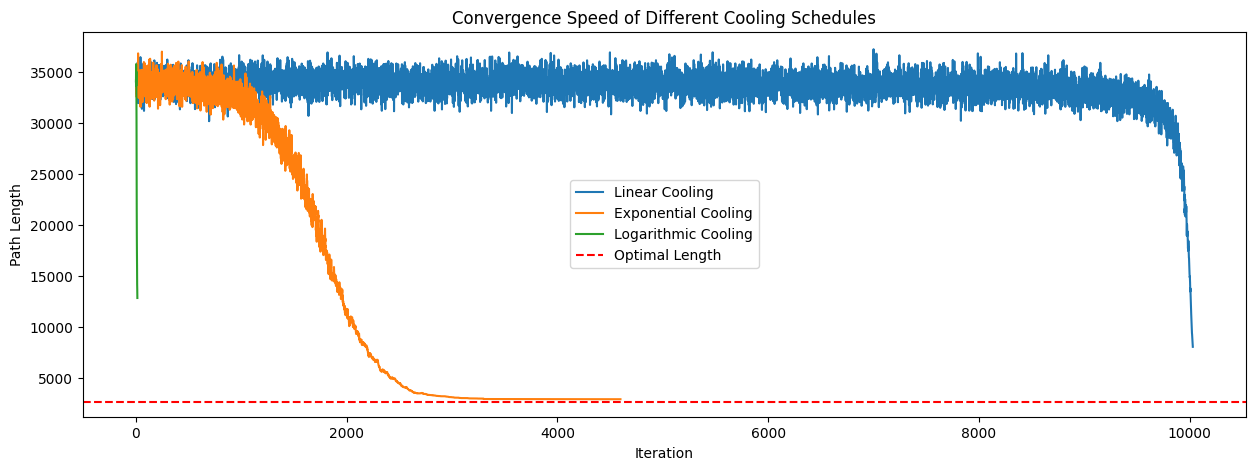

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 之前的函数定义（parse_tsp, distance, path_length, two_opt_swap, parse_opt_tour, calculate_opt_length）

def two_opt_swap(tour, i, j):
    new_tour = np.concatenate([tour[:i], tour[i:j + 1][::-1], tour[j + 1:]])
    return new_tour

def simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    best_tour = np.random.permutation(len(cities))
    best_length = path_length(cities, best_tour)
    iteration = 1
    lengths = []  # 用于记录每次迭代的最佳路径长度

    while current_temp > final_temp:
        for _ in range(len(cities)):
            i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
            new_tour = two_opt_swap(best_tour, i, j)
            new_length = path_length(cities, new_tour)

            if new_length < best_length or np.random.rand() < np.exp((best_length - new_length) / current_temp):
                best_tour = new_tour
                best_length = new_length

        lengths.append(best_length)  # 记录当前最佳长度
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1

    return best_length, lengths

# 不同的冷却计划定义（linear_cooling, exponential_cooling, logarithmic_cooling）

def multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, cooling_schedule):
    best_lengths = []
    
    for _ in range(runs):
        _, lengths = simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule)
        best_lengths.append(lengths)
    
    return best_lengths

# 导入数据
cities = parse_tsp('a280.tsp.txt')
opt_tour = parse_opt_tour('a280.opt.tour.txt')
opt_length = calculate_opt_length(cities, opt_tour)

# 设置参数
runs = 1  # 运行次数减少以减少计算时间
initial_temp = 10000
final_temp = 0.01
alpha = 0.997

# 绘制收敛速度图
plt.figure(figsize=(15, 5))
for name, strategy in cooling_strategies.items():
    lengths = multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, strategy)
    avg_lengths = np.mean(lengths, axis=0)
    plt.plot(avg_lengths, label=name)

plt.axhline(y=opt_length, color='r', linestyle='--', label='Optimal Length')
plt.xlabel('Iteration')
plt.ylabel('Path Length')
plt.title('Convergence Speed of Different Cooling Schedules')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 假设 simulated_annealing, linear_cooling, exponential_cooling, logarithmic_cooling 函数已定义

# 冷却计划定义
def linear_cooling(current_temp, alpha, iteration):
    return current_temp - alpha

def exponential_cooling(current_temp, alpha, iteration):
    return current_temp * alpha

def logarithmic_cooling(current_temp, alpha, iteration):
    return current_temp / np.log(iteration + 1)

# 冷却计划
cooling_schedules = {
    'linear': linear_cooling,
    'exponential': exponential_cooling,
    'logarithmic': logarithmic_cooling
}

# 数据收集
results = {schedule: [] for schedule in cooling_schedules}
runs_per_schedule = 15  # 每种冷却计划运行的次数
initial_temp = 10000   # 初始温度
final_temp = 0.01      # 最终温度
alpha = 0.997          # 冷却率
markov_chain_length = 100  # 马尔可夫链长度

for schedule_name, schedule_func in cooling_schedules.items():
    for _ in range(runs_per_schedule):
        _, length = simulated_annealing(cities, initial_temp, final_temp, alpha, schedule_func, markov_chain_length)
        results[schedule_name].append(length)

# 使用 t-检验进行两两比较
comparisons = [('linear', 'exponential'), ('linear', 'logarithmic'), ('exponential', 'logarithmic')]
t_test_results = {}

for comp in comparisons:
    schedule1, schedule2 = comp
    t_stat, p_value = stats.ttest_ind(results[schedule1], results[schedule2])
    t_test_results[f'{schedule1} vs {schedule2}'] = (t_stat, p_value)

# 打印 t-检验结果
for comparison, result in t_test_results.items():
    print(f"{comparison}: T-statistic = {result[0]}, P-value = {result[1]}")


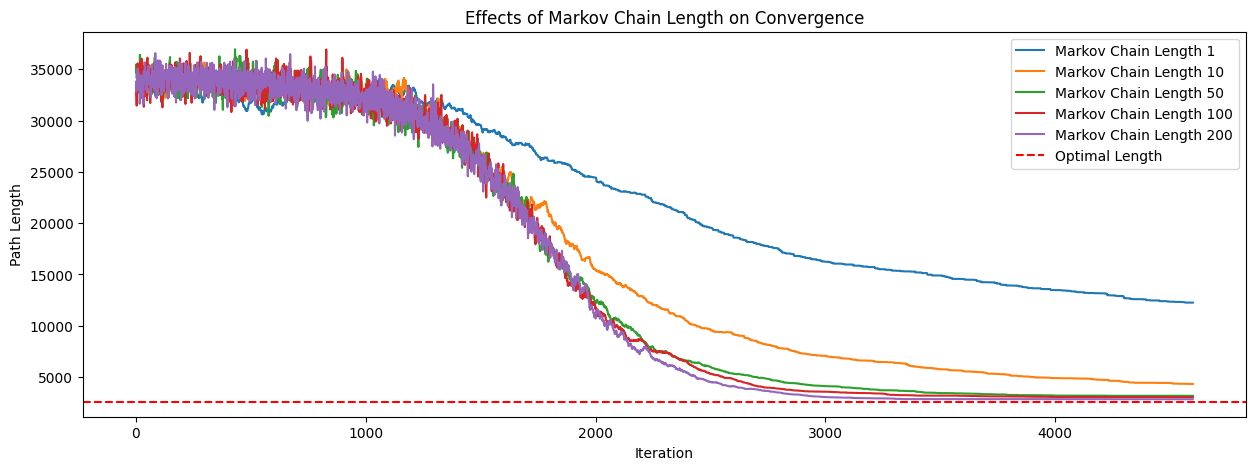

In [14]:
def exponential_cooling(current_temp, alpha, iteration):
    return current_temp * alpha

def simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule, markov_chain_length):
    current_temp = initial_temp
    best_tour = np.random.permutation(len(cities))
    best_length = path_length(cities, best_tour)
    iteration = 1  # 初始化迭代变量
    lengths = [best_length]

    while current_temp > final_temp:
        for _ in range(markov_chain_length):
            i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
            new_tour = two_opt_swap(best_tour, i, j)
            new_length = path_length(cities, new_tour)

            if new_length < best_length or np.random.rand() < np.exp((best_length - new_length) / current_temp):
                best_tour = new_tour
                best_length = new_length
        
        lengths.append(best_length)  # 在每次温度变化后记录路径长度
        current_temp = cooling_schedule(current_temp, alpha, iteration)  # 使用当前迭代次数更新温度
        iteration += 1  # 增加迭代次数

    return best_length, lengths


markov_lengths = [1, 10, 50, 100, 200]  # 可根据需要调整这些值
results = {}

for length in markov_lengths:
    _, lengths = simulated_annealing(cities, initial_temp, final_temp, alpha, exponential_cooling, length)
    results[length] = lengths
    
# 修改绘图代码部分
plt.figure(figsize=(15, 5))
for length in markov_lengths:
    _, lengths = simulated_annealing(cities, initial_temp, final_temp, alpha, exponential_cooling, length)
    plt.plot(range(len(lengths)), lengths, label=f'Markov Chain Length {length}')  # 使用正确的迭代次数范围

plt.axhline(y=opt_length, color='r', linestyle='--', label='Optimal Length')
plt.xlabel('Iteration')
plt.ylabel('Path Length')
plt.title('Effects of Markov Chain Length on Convergence')
plt.legend()
plt.show()
